# Jan 31st, 2022 (small memship vote: draft)

**Motivation**: Node membership: remove small values based on a voting mechanism. <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


from scipy.ndimage import gaussian_filter

def show_h(proj_h, proj_hr, idx: int = 0, cmap='icefire', interp='antialiased'):
    fig, axes = create_figure(
        1, 4, (10., 2), width_ratios=[1.7, 1, 1, 1.7])

    x2plt = proj_h['flat'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[0].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[0], shrink=0.4)

    x2plt = proj_h['top'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[1].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['top'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[2].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['flat'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[3].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[3], shrink=0.4)

    remove_ticks(axes)
    plt.show()


def plot_df_se(df, title=None, bbox_to_anchor=(1.07, 0.55)):
    fg = sns.catplot(
        data=df,
        x='oc_idx',
        y='SE',
        hue='label',
        col='bin_idx',
        col_wrap=2,
        kind='point',
        height=3.5,
        ci=None,
    )
    for ax in fg.axes.flat:
        ax.grid(ls=':')
        ax.set_title(ax.get_title(), fontsize=13)
        ax.set_xlabel(ax.xaxis.get_label().get_text(), fontsize=13)
        ax.set_ylabel(ax.yaxis.get_label().get_text(), fontsize=13)

    plt.setp(fg.legend, bbox_to_anchor=bbox_to_anchor)
    for text in fg.legend.get_texts():
        plt.setp(text, fontsize=14)
    fg.legend.set_title(title)
    plt.setp(fg.legend.get_title(), fontsize=15)
    plt.show()
    
    return fg


def node_vote_plots(
    gr: Group,
    n_resamples: int = 5000,
    ci: float = 0.99,
    thres: float = 0.01, ):
    
    pi = pi_from_gam(gr.run_centroids)
    i, j, k, kk, nn = pi.shape
    dims = {'sub': i, 'ses': j, 'run': k}

    b_anim = bootstrap(
        x=pi,
        n_resamples=n_resamples,
        batch=5,
        skip=['sub'],
        dims=dims,
        est=None,
    )
    b_anim_avg = bn.nanmean(bn.nanmean(b_anim, 3), 2)
    se_anim = np.nanstd(b_anim_avg, axis=0, ddof=1)
    
    votes_dict = gr.cast_votes(se_anim, ci, thres)
    
    save_dir = pjoin(tmp_dir, f'node-vote_k-{gr.num_k}-{gr.perc}_ci-{ci}')
    os.makedirs(save_dir, exist_ok=True)
    
    for nn in tqdm(gr.n2l):
        fig, axes = create_figure(10, 5, (13, 24), 'all')
        for anim in range(10):
            num_missing = pi[anim].reshape(-1, *pi.shape[-2:])
            num_missing = np.isnan(num_missing).mean(1).mean(-1)
            num_missing = (num_missing == 1).sum()
            dof = j * k - num_missing - 1
            t_val = sp_stats.t.ppf(ci, dof)

            for kk in range(5):
                ax = axes[anim, kk]

                mu = gr.anim_pi[anim, kk, nn]
                se = se_anim[anim, kk, nn]

                x2plt = b_anim_avg[:, anim, kk, nn]
                try:
                    sns.kdeplot(x2plt[np.isfinite(x2plt)], fill=True, ax=ax)
                except:
                    continue
                ax.axvline(mu, ls='--', color='k', label='mean')
                ax.axvline(mu - t_val * se, ls='--', color='r', lw=1.3, label=f"ci={ci:0.2f}")
                ax.axvline(mu + t_val * se, ls='--', color='r', lw=1.3)

                ax.set_xlim(0, 1)
                ax.grid()

                if anim == 0:
                    msg = f"OC_{kk + 1}\n("
                    msg += 'reject' if votes_dict['votes_majority'][nn][kk] else 'accept'
                    msg += f": {votes_dict['votes_portion'][nn][kk]:0.3f})\n\n"
                else:
                    msg = ''
                msg += f"lower: {mu - t_val * se:0.2f}"
                ax.set_title(msg, fontsize=13)

                if kk == 4:
                    ax.legend()

                if kk == 0:
                    ax.set_ylabel(f"{mice.get_key(anim + 1)}", fontsize=12, labelpad=10)
                else:
                    ax.set_ylabel('')

        sup = fig.suptitle(f"Node # {nn + 1}", fontsize=17, y=1.015)
        file = pjoin(save_dir, f"mode-{gr.mode}_node{nn+1:03d}.pdf")
        fig.savefig(file, bbox_inches='tight')
        plt.close()

    return b_anim, b_anim_avg, se_anim, votes_dict

In [3]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

props_base = {
    'num_k': 5,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}

## p10-sample

### Prepare

In [4]:
props_ca = {'perc': 'p10-sample', **props_base}
props_bold = {'perc': 'p10-sample', **props_base}

gr_ca = Group(mode='ca2', centroids_from='runs', **props_ca).fit_group()
gr_bold = Group(mode='bold-lite', centroids_from='runs', **props_bold).fit_group()

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

### Membership plot

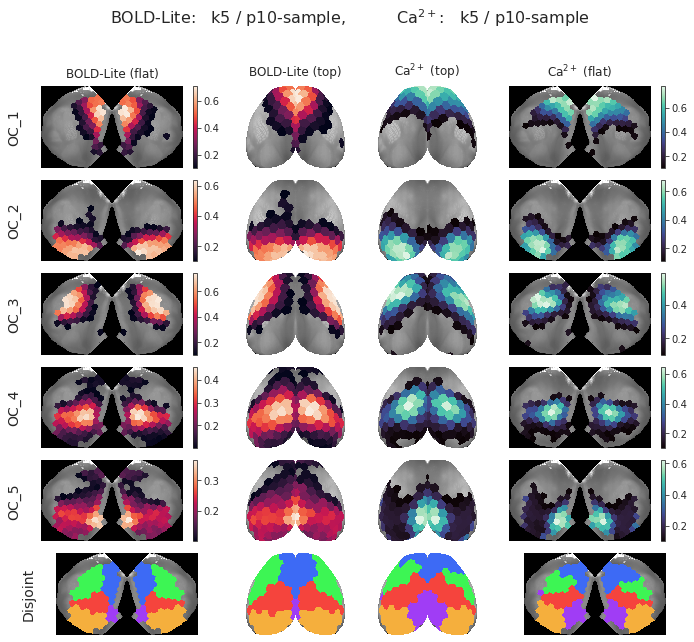

In [5]:
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

In [6]:
gr_bold.pi_symmetry_score(decimals=5)

(
    {1: 0.99369, 2: 0.99514, 3: 0.99294, 4: 0.99334, 5: 0.99632, -1: 0.99428},
    {1: 0.97701, 2: 0.98851, 3: 0.96552, 4: 0.97701, 5: 1.0, -1: 0.98161}
)

In [7]:
gr_ca.pi_symmetry_score(decimals=5)

(
    {1: 0.98681, 2: 0.99326, 3: 0.97899, 4: 0.99218, 5: 0.98576, -1: 0.9874},
    {1: 0.91954, 2: 0.98851, 3: 0.89655, 4: 0.95402, 5: 0.98851, -1: 0.94943}
)

### Node vote plots

#### Ca2

In [8]:
# b_anim, b_anim_avg, se_anim, votes_dict = node_vote_plots(gr_ca)

  0%|          | 0/174 [00:00<?, ?it/s]

In [10]:
pi = pi_from_gam(gr_ca.run_centroids)
i, j, k = pi.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}

b_anim = bootstrap(
    x=pi,
    n_resamples=10000,
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim_avg = bn.nanmean(bn.nanmean(b_anim, 3), 2)
se_anim = np.nanstd(b_anim_avg, axis=0, ddof=1)

In [11]:
votes_dict = gr_ca.cast_votes(se_anim, 0.99, 0.01)

##### Apply vote: per animal

In [12]:
pi = pi_from_gam(gr_ca.run_centroids)
pi_prune = dc(pi)
for node in gr_ca.n2l:
    for anim in range(len(pi)):
        vote = votes_dict['votes'][node, anim]
        vote = vote.reshape(1, 1, -1).astype(bool)
        vote = np.repeat(vote, pi.shape[1], axis=0)
        vote = np.repeat(vote, pi.shape[2], axis=1)
        pi_prune[anim, ..., node][vote] = 0.
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune_avg = bn.nanmean(bn.nanmean(bn.nanmean(pi_prune, 2), 1), 0)

pi_prune.shape, pi_prune_avg.shape

((10, 3, 4, 5, 174), (5, 174))

In [13]:
collections.Counter(np.round(np.nansum(pi, -2), 5).flat).most_common()

[(1.0, 16878), (0.0, 4002)]

In [14]:
collections.Counter(np.round(np.nansum(pi_prune, -2), 5).flat).most_common()

[(1.0, 16389), (0.0, 4491)]

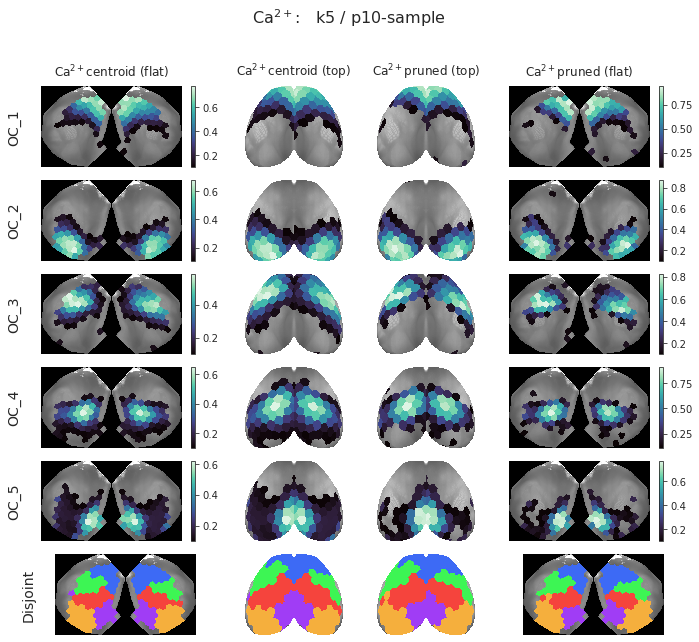

In [15]:
fig, _ = gr_ca.show(
    proj_ca, gr_ca.project_vec(pi_prune_avg),
    labels=(r'Ca$^{2+}$' + 'centroid', r'Ca$^{2+}$' + 'pruned'),
    cmaps=('mako',) * 2,
    display=False,
)
sup = r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

In [16]:
gr_ca.pi_symmetry_score(decimals=3)

(
    {1: 0.987, 2: 0.993, 3: 0.979, 4: 0.992, 5: 0.986, -1: 0.987},
    {1: 0.92, 2: 0.989, 3: 0.897, 4: 0.954, 5: 0.989, -1: 0.949}
)

In [17]:
gr_ca.pi_symmetry_score(pi_prune_avg, decimals=3)

(
    {1: 0.966, 2: 0.985, 3: 0.934, 4: 0.972, 5: 0.969, -1: 0.965},
    {1: 0.92, 2: 0.977, 3: 0.897, 4: 0.943, 5: 0.966, -1: 0.94}
)

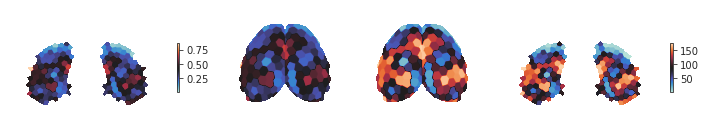

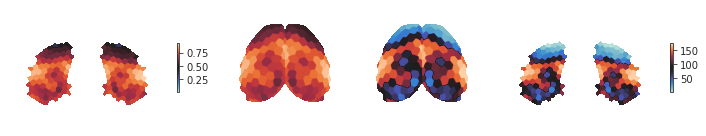

In [18]:
pi_pr_anim = bn.nanmean(bn.nanmean(pi_prune, 2), 1)
h_prune = sp_stats.entropy(pi_pr_anim, axis=-2) 
h_prune /= np.log(pi_prune.shape[-2])
h_prune = bn.nanmean(h_prune, 0)
hr_prune = sp_stats.rankdata(h_prune, axis=-1)
proj_h_prune = gr_ca.project_vec(h_prune, add_disjoint=False)
proj_hr_prune = gr_ca.project_vec(hr_prune, add_disjoint=False)

show_h(proj_h_prune, proj_hr_prune)
show_h(
    gr_ca.project_vec(gr_ca.grp_h, add_disjoint=False),
    gr_ca.project_vec(gr_ca.grp_hr, add_disjoint=False),
)

In [19]:
k, n = pi_prune.shape[-2:]
cut, _ = cut_data(
    data=pi_prune.reshape(-1, k, n),
    bins=gr_ca.bins,
    oc_only=True,
)
cut = cut.reshape((*pi_prune.shape[:-2], k, -1))
cut_avg = bn.nanmean(bn.nanmean(bn.nanmean(cut, 2), 1), 0)
cut.shape, cut_avg.shape

((10, 3, 4, 5, 4), (5, 4))

In [20]:
cut_avg

array([[18.86038537, 14.88278844, 15.08682005, 51.17000613],
       [23.49402122, 17.0235948 , 19.6346286 , 39.84775538],
       [25.29565442, 18.72870772, 16.5330327 , 39.44260516],
       [27.89474544, 20.93993823, 19.23774257, 31.92757376],
       [31.46899692, 17.02883585, 12.55556582, 38.94660141]])

In [21]:
gr_ca.grp_cut

memmap([[27.27210535, 20.36025282, 22.9098823 , 29.45775953],
        [32.99400881, 19.80615903, 25.40967054, 21.79016162],
        [36.18535592, 23.68444197, 23.71037431, 16.41982779],
        [38.84533509, 26.27109344, 24.04243461, 10.84113686],
        [34.49888038, 19.08804767, 21.03779858, 25.37527338]])

##### Apply vote: majority

In [22]:
pi = pi_from_gam(gr_ca.run_centroids)
pi_prune = dc(pi)
for node in gr_ca.n2l:
    vote = votes_dict['votes_majority'][node]
    vote = vote.reshape(1, 1, 1, -1).astype(bool)
    vote = np.repeat(vote, pi.shape[0], axis=0)
    vote = np.repeat(vote, pi.shape[1], axis=1)
    vote = np.repeat(vote, pi.shape[2], axis=2)
    pi_prune[..., node][vote] = 0.
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune_avg = bn.nanmean(bn.nanmean(bn.nanmean(pi_prune, 2), 1), 0)

pi_prune.shape, pi_prune_avg.shape

((10, 3, 4, 5, 174), (5, 174))

In [23]:
collections.Counter(np.round(np.nansum(pi, -2), 5).flat).most_common()

[(1.0, 16878), (0.0, 4002)]

In [24]:
collections.Counter(np.round(np.nansum(pi_prune, -2), 5).flat).most_common()

[(1.0, 16878), (0.0, 4002)]

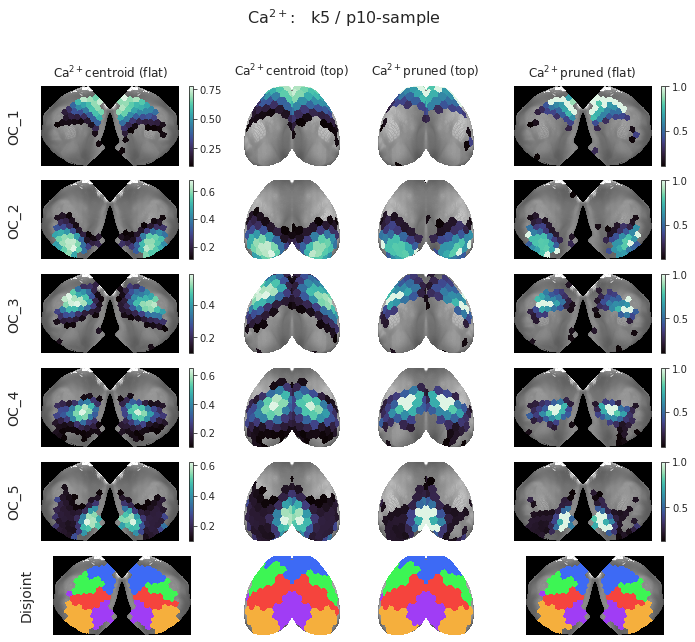

In [25]:
fig, _ = gr_ca.show(
    proj_ca, gr_ca.project_vec(pi_prune_avg),
    labels=(r'Ca$^{2+}$' + 'centroid', r'Ca$^{2+}$' + 'pruned'),
    cmaps=('mako',) * 2,
    display=False,
)
sup = r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

In [26]:
gr_ca.pi_symmetry_score(decimals=3)

(
    {1: 0.987, 2: 0.993, 3: 0.979, 4: 0.992, 5: 0.986, -1: 0.987},
    {1: 0.92, 2: 0.989, 3: 0.897, 4: 0.954, 5: 0.989, -1: 0.949}
)

In [27]:
gr_ca.pi_symmetry_score(pi_prune_avg, decimals=3)

(
    {1: 0.934, 2: 0.956, 3: 0.862, 4: 0.949, 5: 0.958, -1: 0.932},
    {1: 0.92, 2: 0.989, 3: 0.897, 4: 0.966, 5: 0.977, -1: 0.949}
)

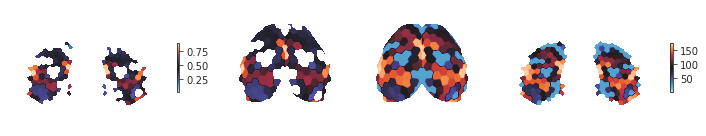

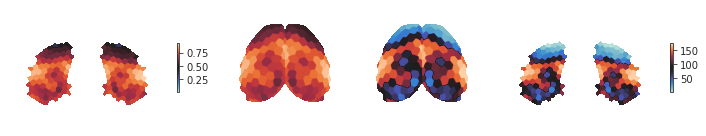

In [28]:
pi_pr_anim = bn.nanmean(bn.nanmean(pi_prune, 2), 1)
h_prune = sp_stats.entropy(pi_pr_anim, axis=-2) 
h_prune /= np.log(pi_prune.shape[-2])
h_prune = bn.nanmean(h_prune, 0)
hr_prune = sp_stats.rankdata(h_prune, axis=-1)
proj_h_prune = gr_ca.project_vec(h_prune, add_disjoint=False)
proj_hr_prune = gr_ca.project_vec(hr_prune, add_disjoint=False)

show_h(proj_h_prune, proj_hr_prune)
show_h(
    gr_ca.project_vec(gr_ca.grp_h, add_disjoint=False),
    gr_ca.project_vec(gr_ca.grp_hr, add_disjoint=False),
)

In [29]:
k, n = pi_prune.shape[-2:]
cut, _ = cut_data(
    data=pi_prune.reshape(-1, k, n),
    bins=gr_ca.bins,
    oc_only=True,
)
cut = cut.reshape((*pi_prune.shape[:-2], k, -1))
cut_avg = bn.nanmean(bn.nanmean(bn.nanmean(cut, 2), 1), 0)
cut.shape, cut_avg.shape

((10, 3, 4, 5, 4), (5, 4))

In [30]:
cut_avg

array([[16.21465334, 13.21474784, 15.87317893, 54.69741989],
       [21.91468269, 17.10172954, 19.63931683, 41.34427094],
       [24.10540476, 17.43967253, 16.85579895, 41.59912376],
       [25.36317974, 21.19447826, 18.445423  , 34.996919  ],
       [26.92804524, 15.56417934, 10.52636124, 46.98141417]])

In [31]:
gr_ca.grp_cut

memmap([[27.27210535, 20.36025282, 22.9098823 , 29.45775953],
        [32.99400881, 19.80615903, 25.40967054, 21.79016162],
        [36.18535592, 23.68444197, 23.71037431, 16.41982779],
        [38.84533509, 26.27109344, 24.04243461, 10.84113686],
        [34.49888038, 19.08804767, 21.03779858, 25.37527338]])

#### BOLD-Lite

In [73]:
# b_anim, b_anim_avg, se_anim, votes_dict = node_vote_plots(gr_bold)

  0%|          | 0/174 [00:00<?, ?it/s]

In [32]:
pi = pi_from_gam(gr_bold.run_centroids)
i, j, k = pi.shape[:3]
dims = {'sub': i, 'ses': j, 'run': k}

b_anim = bootstrap(
    x=pi,
    n_resamples=10000,
    batch=5,
    skip=['sub'],
    dims=dims,
    est=None,
)
b_anim_avg = bn.nanmean(bn.nanmean(b_anim, 3), 2)
se_anim = np.nanstd(b_anim_avg, axis=0, ddof=1)

In [33]:
votes_dict = gr_bold.cast_votes(se_anim, 0.99, 0.01)

##### Apply vote: per animal

In [34]:
pi = pi_from_gam(gr_bold.run_centroids)
pi_prune = dc(pi)
for node in gr_bold.n2l:
    for anim in range(len(pi)):
        vote = votes_dict['votes'][node, anim]
        vote = vote.reshape(1, 1, -1).astype(bool)
        vote = np.repeat(vote, pi.shape[1], axis=0)
        vote = np.repeat(vote, pi.shape[2], axis=1)
        pi_prune[anim, ..., node][vote] = 0.
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune_avg = bn.nanmean(bn.nanmean(bn.nanmean(pi_prune, 2), 1), 0)

pi_prune.shape, pi_prune_avg.shape

((10, 3, 4, 5, 174), (5, 174))

In [35]:
collections.Counter(np.round(np.nansum(pi, -2), 5).flat).most_common()

[(1.0, 19218), (0.0, 1662)]

In [36]:
collections.Counter(np.round(np.nansum(pi_prune, -2), 5).flat).most_common()

[(1.0, 18691), (0.0, 2189)]

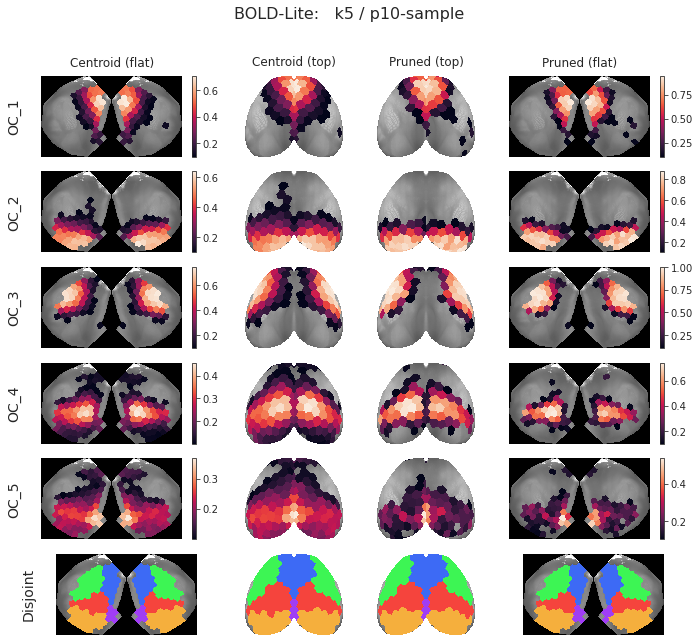

In [37]:
fig, _ = gr_bold.show(
    proj_bold, gr_bold.project_vec(pi_prune_avg),
    labels=('Centroid', 'Pruned'),
    cmaps=('rocket',) * 2,
    display=False,
)
sup = r"BOLD-Lite:   " + f"k{props_bold.get('num_k')} / {props_bold.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

In [38]:
gr_bold.pi_symmetry_score(decimals=3)

(
    {1: 0.994, 2: 0.995, 3: 0.993, 4: 0.993, 5: 0.996, -1: 0.994},
    {1: 0.977, 2: 0.989, 3: 0.966, 4: 0.977, 5: 1.0, -1: 0.982}
)

In [39]:
gr_bold.pi_symmetry_score(pi_prune_avg, decimals=3)

(
    {1: 0.978, 2: 0.992, 3: 0.992, 4: 0.973, 5: 0.965, -1: 0.98},
    {1: 0.977, 2: 0.977, 3: 0.966, 4: 0.977, 5: 0.989, -1: 0.977}
)

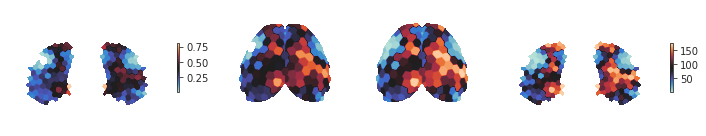

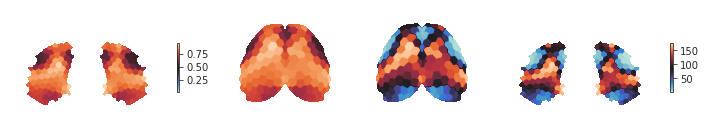

In [40]:
pi_pr_anim = bn.nanmean(bn.nanmean(pi_prune, 2), 1)
h_prune = sp_stats.entropy(pi_pr_anim, axis=-2) 
h_prune /= np.log(pi_prune.shape[-2])
h_prune = bn.nanmean(h_prune, 0)
hr_prune = sp_stats.rankdata(h_prune, axis=-1)
proj_h_prune = gr_bold.project_vec(h_prune, add_disjoint=False)
proj_hr_prune = gr_bold.project_vec(hr_prune, add_disjoint=False)

show_h(proj_h_prune, proj_hr_prune)
show_h(
    gr_bold.project_vec(gr_bold.grp_h, add_disjoint=False),
    gr_bold.project_vec(gr_bold.grp_hr, add_disjoint=False),
)

In [41]:
k, n = pi_prune.shape[-2:]
cut, _ = cut_data(
    data=pi_prune.reshape(-1, k, n),
    bins=gr_bold.bins,
    oc_only=True,
)
cut = cut.reshape((*pi_prune.shape[:-2], k, -1))
cut_avg = bn.nanmean(bn.nanmean(bn.nanmean(cut, 2), 1), 0)
cut.shape, cut_avg.shape

((10, 3, 4, 5, 4), (5, 4))

In [42]:
cut_avg

array([[18.58335445, 13.86668062, 13.72291368, 53.82705126],
       [17.90560724, 11.68728979, 12.37301584, 58.03408713],
       [17.03114833, 10.05239323,  8.97158816, 63.94487028],
       [27.43775321, 18.09895692, 16.69152444, 37.77176543],
       [37.16882815, 20.57564838, 16.31926682, 25.93625665]])

In [44]:
gr_bold.grp_cut

memmap([[34.49658913, 21.72096749, 19.23802105, 24.54442233],
        [30.71334124, 18.87001928, 23.24186342, 27.17477606],
        [32.37820525, 17.09529263, 20.24083112, 30.28567099],
        [44.97095059, 24.82730091, 19.47182073, 10.72992777],
        [46.51726915, 25.54219308, 19.26450682,  8.67603096]])

##### Apply vote: majority

In [45]:
pi = pi_from_gam(gr_bold.run_centroids)
pi_prune = dc(pi)
for node in gr_bold.n2l:
    vote = votes_dict['votes_majority'][node]
    vote = vote.reshape(1, 1, 1, -1).astype(bool)
    vote = np.repeat(vote, pi.shape[0], axis=0)
    vote = np.repeat(vote, pi.shape[1], axis=1)
    vote = np.repeat(vote, pi.shape[2], axis=2)
    pi_prune[..., node][vote] = 0.
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune_avg = bn.nanmean(bn.nanmean(bn.nanmean(pi_prune, 2), 1), 0)

pi_prune.shape, pi_prune_avg.shape

((10, 3, 4, 5, 174), (5, 174))

In [46]:
collections.Counter(np.round(np.nansum(pi, -2), 5).flat).most_common()

[(1.0, 19218), (0.0, 1662)]

In [47]:
collections.Counter(np.round(np.nansum(pi_prune, -2), 5).flat).most_common()

[(1.0, 19218), (0.0, 1662)]

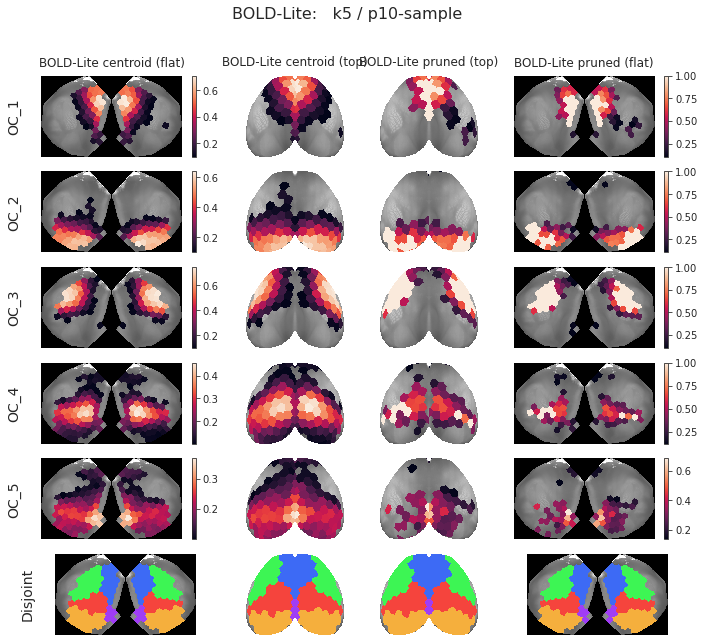

In [48]:
fig, _ = gr_bold.show(
    proj_bold, gr_bold.project_vec(pi_prune_avg),
    labels=('BOLD-Lite centroid', 'BOLD-Lite pruned'),
    cmaps=('rocket',) * 2,
    display=False,
)
sup = r"BOLD-Lite:   " + f"k{props_bold.get('num_k')} / {props_bold.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

In [49]:
gr_bold.pi_symmetry_score(decimals=3)

(
    {1: 0.994, 2: 0.995, 3: 0.993, 4: 0.993, 5: 0.996, -1: 0.994},
    {1: 0.977, 2: 0.989, 3: 0.966, 4: 0.977, 5: 1.0, -1: 0.982}
)

In [50]:
gr_bold.pi_symmetry_score(pi_prune_avg, decimals=3)

(
    {1: 0.96, 2: 0.931, 3: 0.971, 4: 0.775, 5: 0.831, -1: 0.894},
    {1: 0.989, 2: 0.977, 3: 0.989, 4: 0.977, 5: 1.0, -1: 0.986}
)

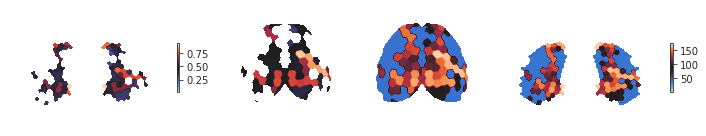

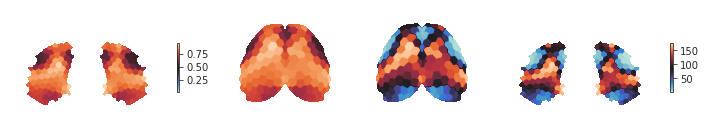

In [51]:
pi_pr_anim = bn.nanmean(bn.nanmean(pi_prune, 2), 1)
h_prune = sp_stats.entropy(pi_pr_anim, axis=-2) 
h_prune /= np.log(pi_prune.shape[-2])
h_prune = bn.nanmean(h_prune, 0)
hr_prune = sp_stats.rankdata(h_prune, axis=-1)
proj_h_prune = gr_bold.project_vec(h_prune, add_disjoint=False)
proj_hr_prune = gr_bold.project_vec(hr_prune, add_disjoint=False)

show_h(proj_h_prune, proj_hr_prune)
show_h(
    gr_bold.project_vec(gr_bold.grp_h, add_disjoint=False),
    gr_bold.project_vec(gr_bold.grp_hr, add_disjoint=False),
)

In [52]:
k, n = pi_prune.shape[-2:]
cut, _ = cut_data(
    data=pi_prune.reshape(-1, k, n),
    bins=gr_bold.bins,
    oc_only=True,
)
cut = cut.reshape((*pi_prune.shape[:-2], k, -1))
cut_avg = bn.nanmean(bn.nanmean(bn.nanmean(cut, 2), 1), 0)
cut.shape, cut_avg.shape

((10, 3, 4, 5, 4), (5, 4))

In [53]:
cut_avg

array([[15.57994441, 12.12193268, 11.52171819, 60.77640472],
       [15.04533158, 10.41513379, 11.30371742, 63.23581721],
       [13.84443013,  7.98683427,  6.35586103, 71.81287457],
       [23.78265909, 17.37196444, 17.67106733, 41.17430914],
       [36.24202664, 23.27854203, 20.74292543, 19.73650589]])

In [54]:
gr_bold.grp_cut

memmap([[34.49658913, 21.72096749, 19.23802105, 24.54442233],
        [30.71334124, 18.87001928, 23.24186342, 27.17477606],
        [32.37820525, 17.09529263, 20.24083112, 30.28567099],
        [44.97095059, 24.82730091, 19.47182073, 10.72992777],
        [46.51726915, 25.54219308, 19.26450682,  8.67603096]])

## p20-sample

### Prepare

In [4]:
props_ca = {'perc': 'p20-sample', **props_base}
props_bold = {'perc': 'p20-sample', **props_base}

gr_ca = Group(mode='ca2', centroids_from='runs', **props_ca).fit_group()
gr_bold = Group(mode='bold-lite', centroids_from='runs', **props_bold).fit_group()

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

### Membership plot

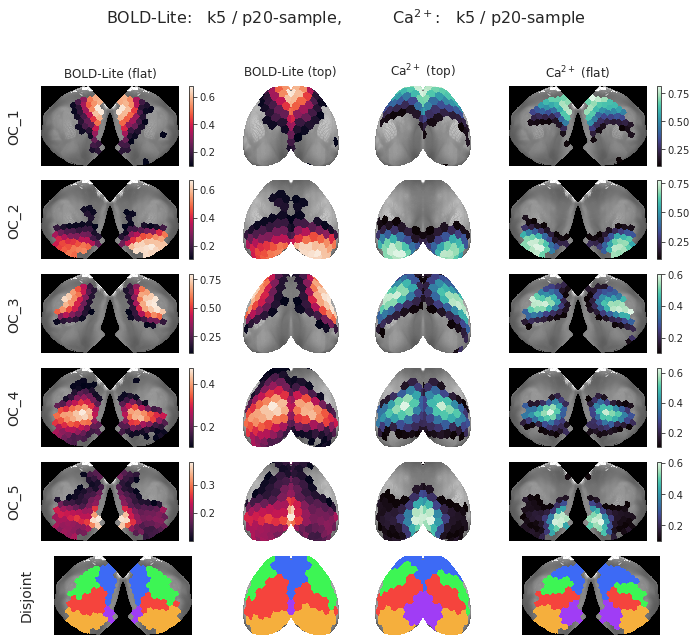

In [5]:
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

In [6]:
gr_bold.pi_symmetry_score(decimals=5)

(
    {1: 0.99524, 2: 0.99079, 3: 0.98515, 4: 0.96904, 5: 0.99135, -1: 0.98631},
    {1: 0.97701, 2: 0.94253, 3: 0.94253, 4: 0.87356, 5: 0.98851, -1: 0.94483}
)

In [7]:
gr_ca.pi_symmetry_score(decimals=5)

(
    {1: 0.98899, 2: 0.9926, 3: 0.97097, 4: 0.99012, 5: 0.99235, -1: 0.98701},
    {1: 0.91954, 2: 0.97701, 3: 0.88506, 4: 0.93103, 5: 0.98851, -1: 0.94023}
)

### Node vote plots

#### Ca2

In [8]:
b_anim, b_anim_avg, se_anim, votes_dict = node_vote_plots(gr_ca)

  0%|          | 0/174 [00:00<?, ?it/s]

##### Apply vote: per animal

In [9]:
pi = pi_from_gam(gr_ca.run_centroids)
pi_prune = dc(pi)
for node in gr_ca.n2l:
    for anim in range(len(pi)):
        vote = votes_dict['votes'][node, anim]
        vote = vote.reshape(1, 1, -1).astype(bool)
        vote = np.repeat(vote, pi.shape[1], axis=0)
        vote = np.repeat(vote, pi.shape[2], axis=1)
        pi_prune[anim, ..., node][vote] = 0.
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune_avg = bn.nanmean(bn.nanmean(bn.nanmean(pi_prune, 2), 1), 0)

pi_prune.shape, pi_prune_avg.shape

((10, 3, 4, 5, 174), (5, 174))

In [10]:
collections.Counter(np.round(np.nansum(pi, -2), 5).flat).most_common()

[(1.0, 17573), (0.0, 3307)]

In [11]:
collections.Counter(np.round(np.nansum(pi_prune, -2), 5).flat).most_common()

[(1.0, 16664), (0.0, 4216)]

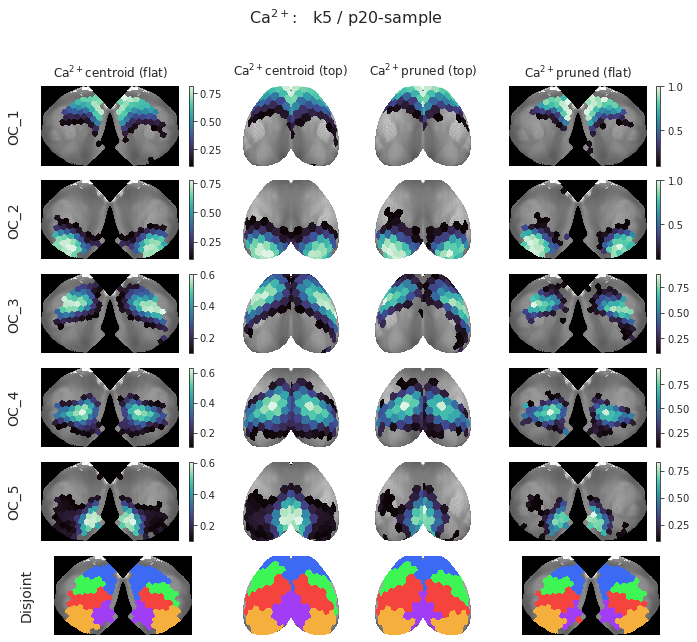

In [12]:
fig, _ = gr_ca.show(
    proj_ca, gr_ca.project_vec(pi_prune_avg),
    labels=(r'Ca$^{2+}$' + 'centroid', r'Ca$^{2+}$' + 'pruned'),
    cmaps=('mako',) * 2,
    display=False,
)
sup = r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

In [13]:
gr_ca.pi_symmetry_score(decimals=3)

(
    {1: 0.989, 2: 0.993, 3: 0.971, 4: 0.99, 5: 0.992, -1: 0.987},
    {1: 0.92, 2: 0.977, 3: 0.885, 4: 0.931, 5: 0.989, -1: 0.94}
)

In [14]:
gr_ca.pi_symmetry_score(pi_prune_avg, decimals=3)

(
    {1: 0.978, 2: 0.977, 3: 0.908, 4: 0.946, 5: 0.975, -1: 0.957},
    {1: 0.931, 2: 0.977, 3: 0.885, 4: 0.897, 5: 0.989, -1: 0.936}
)

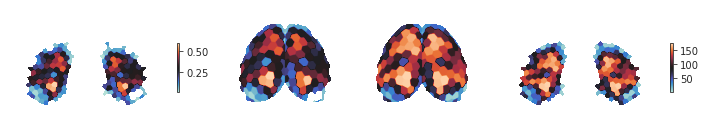

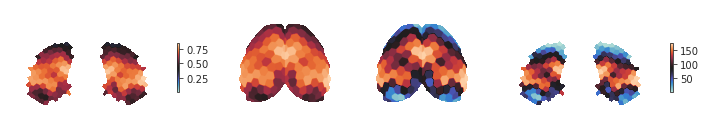

In [15]:
pi_pr_anim = bn.nanmean(bn.nanmean(pi_prune, 2), 1)
h_prune = sp_stats.entropy(pi_pr_anim, axis=-2) 
h_prune /= np.log(pi_prune.shape[-2])
h_prune = bn.nanmean(h_prune, 0)
hr_prune = sp_stats.rankdata(h_prune, axis=-1)
proj_h_prune = gr_ca.project_vec(h_prune, add_disjoint=False)
proj_hr_prune = gr_ca.project_vec(hr_prune, add_disjoint=False)

show_h(proj_h_prune, proj_hr_prune)
show_h(
    gr_ca.project_vec(gr_ca.grp_h, add_disjoint=False),
    gr_ca.project_vec(gr_ca.grp_hr, add_disjoint=False),
)

In [16]:
k, n = pi_prune.shape[-2:]
cut, _ = cut_data(
    data=pi_prune.reshape(-1, k, n),
    bins=gr_ca.bins,
    oc_only=True,
)
cut = cut.reshape((*pi_prune.shape[:-2], k, -1))
cut_avg = bn.nanmean(bn.nanmean(bn.nanmean(cut, 2), 1), 0)
cut.shape, cut_avg.shape

((10, 3, 4, 5, 4), (5, 4))

In [17]:
cut_avg

array([[12.2051097 , 11.83062178, 12.3438842 , 63.62038433],
       [14.66220465, 12.40006268, 10.61975236, 62.31798031],
       [21.66253706, 19.13953891, 16.32547165, 42.87245238],
       [21.28814419, 21.13904845, 20.0218756 , 37.55093176],
       [25.27273623, 17.42943203, 13.46429265, 43.83353909]])

In [18]:
gr_ca.grp_cut

memmap([[25.35927482, 20.01634096, 22.85011621, 31.77426801],
        [26.67313101, 19.34665748, 18.86354963, 35.11666188],
        [34.37846946, 26.66678649, 22.1754886 , 16.77925546],
        [34.70191314, 29.31768091, 24.0320456 , 11.94836034],
        [33.01816719, 21.22151115, 17.34933509, 28.41098657]])

##### Apply vote: majority

In [19]:
pi = pi_from_gam(gr_ca.run_centroids)
pi_prune = dc(pi)
for node in gr_ca.n2l:
    vote = votes_dict['votes_majority'][node]
    vote = vote.reshape(1, 1, 1, -1).astype(bool)
    vote = np.repeat(vote, pi.shape[0], axis=0)
    vote = np.repeat(vote, pi.shape[1], axis=1)
    vote = np.repeat(vote, pi.shape[2], axis=2)
    pi_prune[..., node][vote] = 0.
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune_avg = bn.nanmean(bn.nanmean(bn.nanmean(pi_prune, 2), 1), 0)

pi_prune.shape, pi_prune_avg.shape

((10, 3, 4, 5, 174), (5, 174))

In [20]:
collections.Counter(np.round(np.nansum(pi, -2), 5).flat).most_common()

[(1.0, 17573), (0.0, 3307)]

In [21]:
collections.Counter(np.round(np.nansum(pi_prune, -2), 5).flat).most_common()

[(1.0, 17321), (0.0, 3559)]

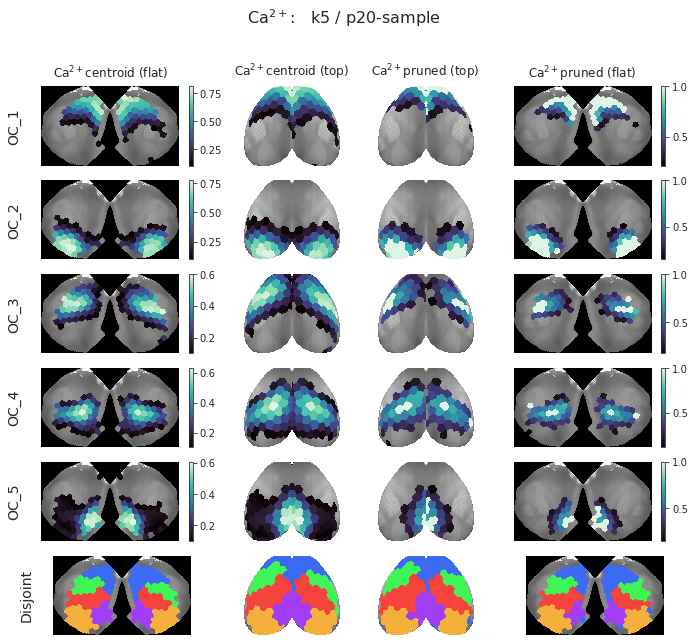

In [22]:
fig, _ = gr_ca.show(
    proj_ca, gr_ca.project_vec(pi_prune_avg),
    labels=(r'Ca$^{2+}$' + 'centroid', r'Ca$^{2+}$' + 'pruned'),
    cmaps=('mako',) * 2,
    display=False,
)
sup = r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

In [23]:
gr_ca.pi_symmetry_score(decimals=3)

(
    {1: 0.989, 2: 0.993, 3: 0.971, 4: 0.99, 5: 0.992, -1: 0.987},
    {1: 0.92, 2: 0.977, 3: 0.885, 4: 0.931, 5: 0.989, -1: 0.94}
)

In [24]:
gr_ca.pi_symmetry_score(pi_prune_avg, decimals=3)

(
    {1: 0.961, 2: 0.967, 3: 0.867, 4: 0.89, 5: 0.956, -1: 0.928},
    {1: 0.928, 2: 0.976, 3: 0.892, 4: 0.916, 5: 0.976, -1: 0.937}
)

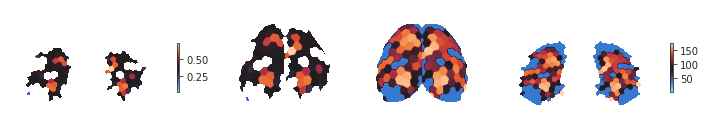

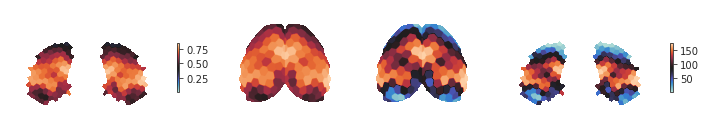

In [25]:
pi_pr_anim = bn.nanmean(bn.nanmean(pi_prune, 2), 1)
h_prune = sp_stats.entropy(pi_pr_anim, axis=-2) 
h_prune /= np.log(pi_prune.shape[-2])
h_prune = bn.nanmean(h_prune, 0)
hr_prune = sp_stats.rankdata(h_prune, axis=-1)
proj_h_prune = gr_ca.project_vec(h_prune, add_disjoint=False)
proj_hr_prune = gr_ca.project_vec(hr_prune, add_disjoint=False)

show_h(proj_h_prune, proj_hr_prune)
show_h(
    gr_ca.project_vec(gr_ca.grp_h, add_disjoint=False),
    gr_ca.project_vec(gr_ca.grp_hr, add_disjoint=False),
)

In [26]:
k, n = pi_prune.shape[-2:]
cut, _ = cut_data(
    data=pi_prune.reshape(-1, k, n),
    bins=gr_ca.bins,
    oc_only=True,
)
cut = cut.reshape((*pi_prune.shape[:-2], k, -1))
cut_avg = bn.nanmean(bn.nanmean(bn.nanmean(cut, 2), 1), 0)
cut.shape, cut_avg.shape

((10, 3, 4, 5, 4), (5, 4))

In [27]:
cut_avg

array([[11.60971334, 10.79992947, 13.15218439, 64.4381728 ],
       [14.08499399, 12.52036985,  9.92111014, 63.47352603],
       [22.5112367 , 17.8976048 , 15.27076126, 44.32039725],
       [20.62934689, 21.7466922 , 21.81657202, 35.80738889],
       [20.78980816, 15.60352349,  9.85480348, 53.75186487]])

In [28]:
gr_ca.grp_cut

memmap([[25.35927482, 20.01634096, 22.85011621, 31.77426801],
        [26.67313101, 19.34665748, 18.86354963, 35.11666188],
        [34.37846946, 26.66678649, 22.1754886 , 16.77925546],
        [34.70191314, 29.31768091, 24.0320456 , 11.94836034],
        [33.01816719, 21.22151115, 17.34933509, 28.41098657]])

#### BOLD-Lite

In [29]:
b_anim, b_anim_avg, se_anim, votes_dict = node_vote_plots(gr_bold)

  0%|          | 0/174 [00:00<?, ?it/s]

##### Apply vote: per animal

In [30]:
pi = pi_from_gam(gr_bold.run_centroids)
pi_prune = dc(pi)
for node in gr_bold.n2l:
    for anim in range(len(pi)):
        vote = votes_dict['votes'][node, anim]
        vote = vote.reshape(1, 1, -1).astype(bool)
        vote = np.repeat(vote, pi.shape[1], axis=0)
        vote = np.repeat(vote, pi.shape[2], axis=1)
        pi_prune[anim, ..., node][vote] = 0.
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune_avg = bn.nanmean(bn.nanmean(bn.nanmean(pi_prune, 2), 1), 0)

pi_prune.shape, pi_prune_avg.shape

((10, 3, 4, 5, 174), (5, 174))

In [31]:
collections.Counter(np.round(np.nansum(pi, -2), 5).flat).most_common()

[(1.0, 19692), (0.0, 1188)]

In [32]:
collections.Counter(np.round(np.nansum(pi_prune, -2), 5).flat).most_common()

[(1.0, 19044), (0.0, 1836)]

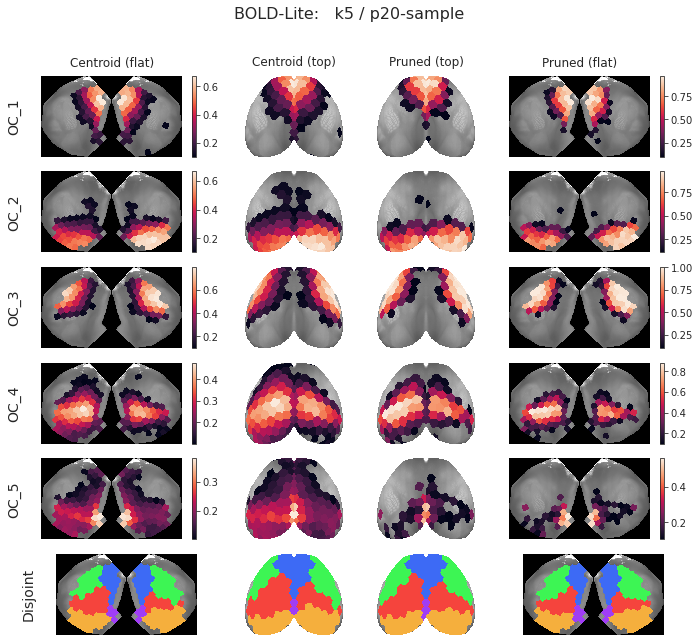

In [33]:
fig, _ = gr_bold.show(
    proj_bold, gr_bold.project_vec(pi_prune_avg),
    labels=('Centroid', 'Pruned'),
    cmaps=('rocket',) * 2,
    display=False,
)
sup = r"BOLD-Lite:   " + f"k{props_bold.get('num_k')} / {props_bold.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

In [34]:
gr_bold.pi_symmetry_score(decimals=3)

(
    {1: 0.995, 2: 0.991, 3: 0.985, 4: 0.969, 5: 0.991, -1: 0.986},
    {1: 0.977, 2: 0.943, 3: 0.943, 4: 0.874, 5: 0.989, -1: 0.945}
)

In [35]:
gr_bold.pi_symmetry_score(pi_prune_avg, decimals=3)

(
    {1: 0.989, 2: 0.983, 3: 0.985, 4: 0.925, 5: 0.949, -1: 0.966},
    {1: 0.977, 2: 0.954, 3: 0.989, 4: 0.931, 5: 0.989, -1: 0.968}
)

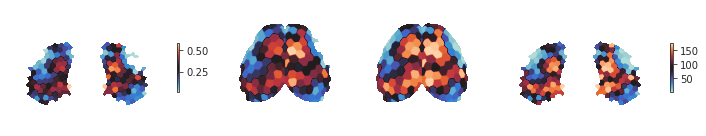

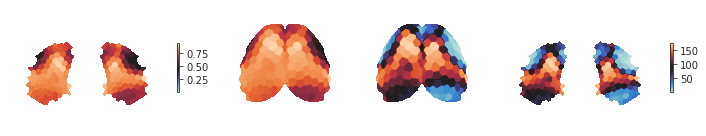

In [36]:
pi_pr_anim = bn.nanmean(bn.nanmean(pi_prune, 2), 1)
h_prune = sp_stats.entropy(pi_pr_anim, axis=-2) 
h_prune /= np.log(pi_prune.shape[-2])
h_prune = bn.nanmean(h_prune, 0)
hr_prune = sp_stats.rankdata(h_prune, axis=-1)
proj_h_prune = gr_bold.project_vec(h_prune, add_disjoint=False)
proj_hr_prune = gr_bold.project_vec(hr_prune, add_disjoint=False)

show_h(proj_h_prune, proj_hr_prune)
show_h(
    gr_bold.project_vec(gr_bold.grp_h, add_disjoint=False),
    gr_bold.project_vec(gr_bold.grp_hr, add_disjoint=False),
)

In [37]:
k, n = pi_prune.shape[-2:]
cut, _ = cut_data(
    data=pi_prune.reshape(-1, k, n),
    bins=gr_bold.bins,
    oc_only=True,
)
cut = cut.reshape((*pi_prune.shape[:-2], k, -1))
cut_avg = bn.nanmean(bn.nanmean(bn.nanmean(cut, 2), 1), 0)
cut.shape, cut_avg.shape

((10, 3, 4, 5, 4), (5, 4))

In [38]:
cut_avg

array([[13.63585668, 11.59332058, 12.83561663, 61.93520611],
       [14.07966723, 11.59996272, 14.20825139, 60.11211865],
       [11.65088047,  8.05016006,  8.43014401, 71.86881545],
       [23.23916236, 17.97973938, 16.23915195, 42.5419463 ],
       [36.21509362, 20.53066145, 15.5374726 , 27.71677234]])

In [39]:
gr_bold.grp_cut

memmap([[35.25878693, 24.28579604, 18.84041316, 21.61500387],
        [31.49803327, 23.17122317, 24.00660292, 21.32414064],
        [28.9771541 , 19.50553565, 19.69573704, 31.8215732 ],
        [42.91457401, 29.34498867, 20.56416208,  7.17627524],
        [45.9183388 , 23.75434539, 20.76910568,  9.55821013]])

##### Apply vote: majority

In [40]:
pi = pi_from_gam(gr_bold.run_centroids)
pi_prune = dc(pi)
for node in gr_bold.n2l:
    vote = votes_dict['votes_majority'][node]
    vote = vote.reshape(1, 1, 1, -1).astype(bool)
    vote = np.repeat(vote, pi.shape[0], axis=0)
    vote = np.repeat(vote, pi.shape[1], axis=1)
    vote = np.repeat(vote, pi.shape[2], axis=2)
    pi_prune[..., node][vote] = 0.
pi_prune /= np.nansum(pi_prune, -2, keepdims=True)
pi_prune_avg = bn.nanmean(bn.nanmean(bn.nanmean(pi_prune, 2), 1), 0)

pi_prune.shape, pi_prune_avg.shape

((10, 3, 4, 5, 174), (5, 174))

In [41]:
collections.Counter(np.round(np.nansum(pi, -2), 5).flat).most_common()

[(1.0, 19692), (0.0, 1188)]

In [42]:
collections.Counter(np.round(np.nansum(pi_prune, -2), 5).flat).most_common()

[(1.0, 19692), (0.0, 1188)]

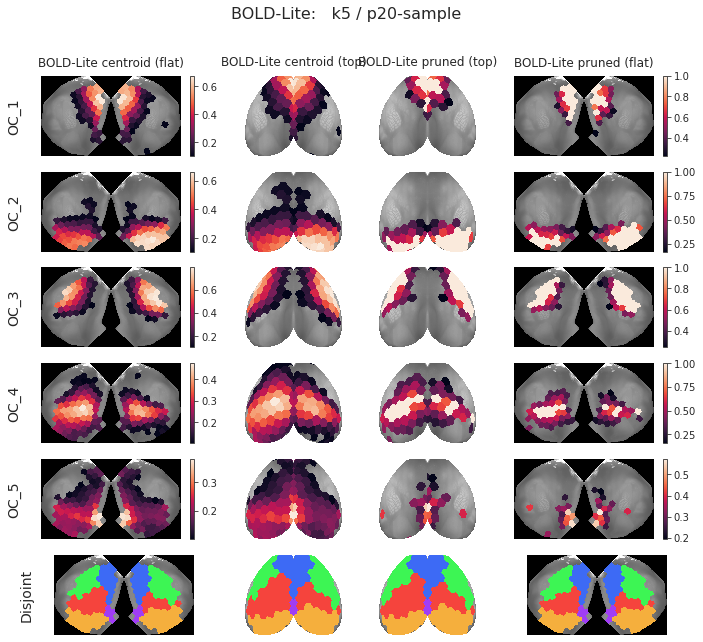

In [43]:
fig, _ = gr_bold.show(
    proj_bold, gr_bold.project_vec(pi_prune_avg),
    labels=('BOLD-Lite centroid', 'BOLD-Lite pruned'),
    cmaps=('rocket',) * 2,
    display=False,
)
sup = r"BOLD-Lite:   " + f"k{props_bold.get('num_k')} / {props_bold.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

In [44]:
gr_bold.pi_symmetry_score(decimals=3)

(
    {1: 0.995, 2: 0.991, 3: 0.985, 4: 0.969, 5: 0.991, -1: 0.986},
    {1: 0.977, 2: 0.943, 3: 0.943, 4: 0.874, 5: 0.989, -1: 0.945}
)

In [45]:
gr_bold.pi_symmetry_score(pi_prune_avg, decimals=3)

(
    {1: 0.969, 2: 0.969, 3: 0.957, 4: 0.883, 5: 0.857, -1: 0.927},
    {1: 0.977, 2: 0.954, 3: 0.966, 4: 0.897, 5: 1.0, -1: 0.959}
)

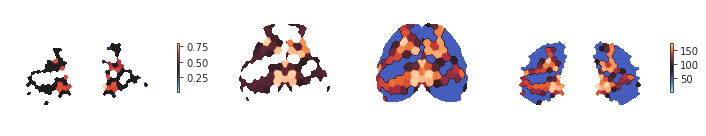

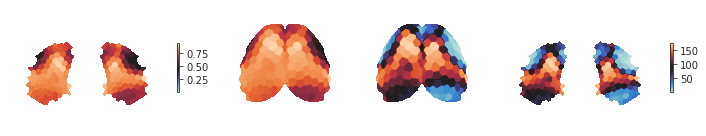

In [46]:
pi_pr_anim = bn.nanmean(bn.nanmean(pi_prune, 2), 1)
h_prune = sp_stats.entropy(pi_pr_anim, axis=-2) 
h_prune /= np.log(pi_prune.shape[-2])
h_prune = bn.nanmean(h_prune, 0)
hr_prune = sp_stats.rankdata(h_prune, axis=-1)
proj_h_prune = gr_bold.project_vec(h_prune, add_disjoint=False)
proj_hr_prune = gr_bold.project_vec(hr_prune, add_disjoint=False)

show_h(proj_h_prune, proj_hr_prune)
show_h(
    gr_bold.project_vec(gr_bold.grp_h, add_disjoint=False),
    gr_bold.project_vec(gr_bold.grp_hr, add_disjoint=False),
)

In [47]:
k, n = pi_prune.shape[-2:]
cut, _ = cut_data(
    data=pi_prune.reshape(-1, k, n),
    bins=gr_bold.bins,
    oc_only=True,
)
cut = cut.reshape((*pi_prune.shape[:-2], k, -1))
cut_avg = bn.nanmean(bn.nanmean(bn.nanmean(cut, 2), 1), 0)
cut.shape, cut_avg.shape

((10, 3, 4, 5, 4), (5, 4))

In [48]:
cut_avg

array([[ 9.2236352 ,  8.57786868,  9.89683156, 72.30166456],
       [11.02548002,  8.7202294 , 11.41543836, 68.83885223],
       [ 9.35932489,  6.99636657,  7.46210837, 76.18220017],
       [20.72634168, 16.42844227, 16.62978832, 46.21542772],
       [36.79936921, 24.05662942, 18.85794621, 20.28605516]])

In [49]:
gr_bold.grp_cut

memmap([[35.25878693, 24.28579604, 18.84041316, 21.61500387],
        [31.49803327, 23.17122317, 24.00660292, 21.32414064],
        [28.9771541 , 19.50553565, 19.69573704, 31.8215732 ],
        [42.91457401, 29.34498867, 20.56416208,  7.17627524],
        [45.9183388 , 23.75434539, 20.76910568,  9.55821013]])

## From Monday (ignore)

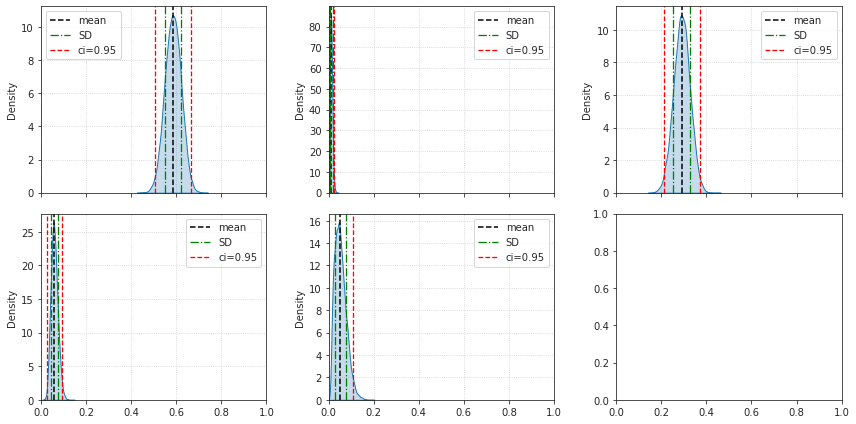

In [11]:
kk = 0
nn = 13

ci = 0.95
dof = 11
t_val = sp_stats.t.ppf((1 + ci) / 2, dof)

means = []
fig, axes = create_figure(2, 3, (12, 6), 'all')
for kk in range(5):
    ax = axes.flat[kk]
    mu, sd = bn.nanmean(b_grp_avg[:, kk, nn]), np.nanstd(b_grp_avg[:, kk, nn], ddof=1)
    means.append(mu)

    sns.kdeplot(b_grp_avg[:, kk, nn], fill=True, ax=ax)
    ax.axvline(mu, ls='--', color='k', label='mean')
    ax.axvline(mu - sd, ls='-.', color='g', lw=1.3, label='SD')
    ax.axvline(mu + sd, ls='-.', color='g', lw=1.3)
    
    ax.axvline(mu - t_val * sd, ls='--', color='r', lw=1.3, label=f"ci={ci:0.2f}")
    ax.axvline(mu + t_val * sd, ls='--', color='r', lw=1.3)
    
    ax.set_xlim(0, 1)
    ax.legend()
    ax.grid()
# trim_axs(axes, 5)
plt.show()

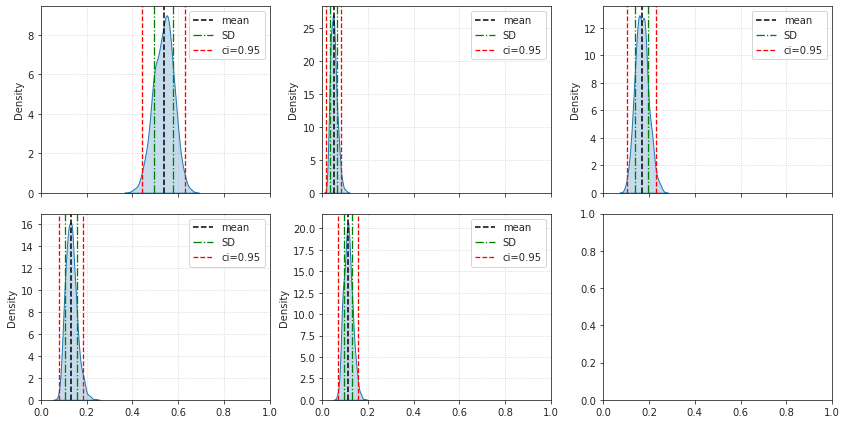

In [19]:
kk = 0
nn = 13

ci = 0.95
dof = 11
t_val = sp_stats.t.ppf((1 + ci) / 2, dof)

means = []
fig, axes = create_figure(2, 3, (12, 6), 'all')
for kk in range(5):
    ax = axes.flat[kk]
    mu, sd = bn.nanmean(b_grp_avg[:, kk, nn]), np.nanstd(b_grp_avg[:, kk, nn], ddof=1)
    means.append(mu)

    sns.kdeplot(b_grp_avg[:, kk, nn], fill=True, ax=ax)
    ax.axvline(mu, ls='--', color='k', label='mean')
    ax.axvline(mu - sd, ls='-.', color='g', lw=1.3, label='SD')
    ax.axvline(mu + sd, ls='-.', color='g', lw=1.3)
    
    ax.axvline(mu - t_val * sd, ls='--', color='r', lw=1.3, label=f"ci={ci:0.2f}")
    ax.axvline(mu + t_val * sd, ls='--', color='r', lw=1.3)
    
    ax.set_xlim(0, 1)
    ax.legend()
    ax.grid()
# trim_axs(axes, 5)
plt.show()

In [31]:
ci, thres = 0.99, 0.01
votes_dict = gr_bold.cast_votes(se_anim, ci, thres)

In [ ]:
k, n = b_grp.shape[-2:]
cut, _ = cut_data(
    data=b_grp.reshape(-1, k, n),
    bins=gr_bold.bins,
    oc_only=True,
)
cut = cut.reshape((*b_grp.shape[:-2], k, -1))
cut_avg = bn.nanmean(bn.nanmean(bn.nanmean(cut, 3), 2), 1)
cut.shape, cut_avg.shape

In [ ]:
cut_avg = bn.nanmean(bn.nanmean(bn.nanmean(cut, 3), 2), 1)
cut.shape, cut_avg.shape

In [ ]:
cut_avg

In [ ]:
gr_bold.grp_cut

## OLD THRESHOLD STUFF

In [30]:
k, n = b.shape[-2:]
cut, _ = cut_data(
    data=b.reshape(-1, k, n),
    bins=gr_bold.bins,
    oc_only=True,
)
cut = cut.reshape((*b.shape[:-2], k, -1))
cut.shape

(1000, 10, 3, 4, 5, 4)

In [31]:
cut_avg = bn.nanmean(bn.nanmean(bn.nanmean(cut, 3), 2), 1)
cut_avg.shape

(1000, 5, 4)

In [32]:
np.nanmean(cut_avg, 0)

array([[35.35257269, 24.25489799, 18.78960105, 21.60292827],
       [31.60505511, 23.205275  , 23.96690542, 21.22276448],
       [28.94195561, 19.42095477, 19.71608786, 31.92100176],
       [42.74773016, 29.43862509, 20.66705075,  7.14659399],
       [46.02433307, 23.7929038 , 20.72464347,  9.45811967]])

In [33]:
gr_bold.grp_cut

memmap([[35.25878693, 24.28579604, 18.84041316, 21.61500387],
        [31.49803327, 23.17122317, 24.00660292, 21.32414064],
        [28.9771541 , 19.50553565, 19.69573704, 31.8215732 ],
        [42.91457401, 29.34498867, 20.56416208,  7.17627524],
        [45.9183388 , 23.75434539, 20.76910568,  9.55821013]])

In [34]:
np.nanstd(cut_avg, 0, ddof=1)

array([[2.23006038, 1.80892416, 1.2541704 , 3.08520803],
       [2.07948807, 1.76397168, 1.85827733, 3.3279419 ],
       [1.95293804, 1.64334958, 1.47204107, 3.2256078 ],
       [2.08587093, 1.4222766 , 1.82057903, 1.54422556],
       [3.075223  , 1.71320115, 1.77817119, 2.10455316]])

### Centroids; threshold at 0.1

In [35]:
pi_bold = pi_from_gam(gr_bold.run_centroids)
pi_bold[pi_bold <= 0.1] = 0
pi_bold /= np.nansum(pi_bold, -2, keepdims=True)
pi_bold.shape

(10, 3, 4, 5, 174)

In [36]:
collections.Counter(np.round(pi_bold.sum(-2).flat, 4)).most_common()[:5]

[(1.0, 19692), (nan, 1), (nan, 1), (nan, 1), (nan, 1)]

In [37]:
dims = {'sub': 10, 'ses': 3, 'run': 4}

b = bootstrap(
    x=pi_bold,
    n_resamples=1000,
    batch=5,
    dims=dims,
    est=None,
)
b.shape

(1000, 10, 3, 4, 5, 174)

In [38]:
tmp = np.round(b.sum(-2), 4)
tmp[np.isnan(tmp)] = -1

In [39]:
collections.Counter(tmp.flat).most_common()[:5]

[(1.0, 19697200), (-1.0, 1182800)]

In [40]:
b_pi = bn.nanmean(bn.nanmean(bn.nanmean(b, 3), 2), 1)
b_pi.shape

(1000, 5, 174)

In [41]:
collections.Counter(np.round(b_pi.sum(-2), 5).flat)

Counter({1.0: 174000})

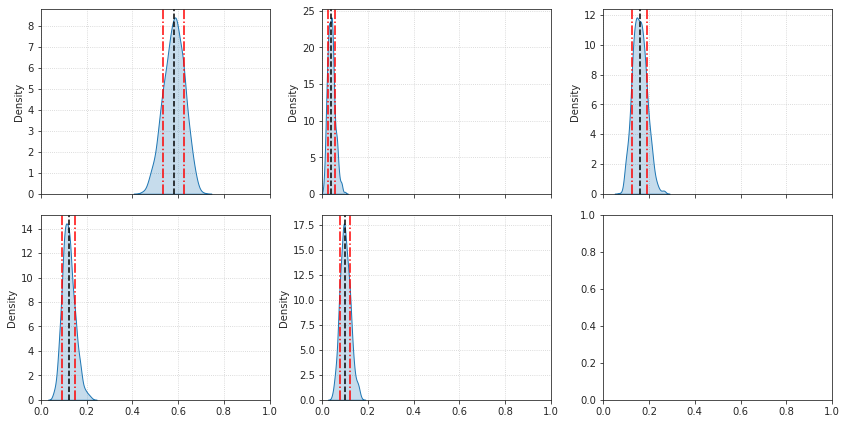

In [42]:
i, j, k = 3, 1, 2
kk = 0
nn = 13

means = []

fig, axes = create_figure(2, 3, (12, 6), 'all')
for kk in range(5):
    ax = axes.flat[kk]
    mu, sd = bn.nanmean(b_pi[:, kk, nn]), np.nanstd(b_pi[:, kk, nn], ddof=1)
    means.append(mu)

    sns.kdeplot(b_pi[:, kk, nn], fill=True, ax=ax)
    ax.axvline(mu, ls='--', color='k')
    ax.axvline(mu - sd, ls='-.', color='r')
    ax.axvline(mu + sd, ls='-.', color='r')
    ax.set_xlim(0, 1)
    ax.grid()
# trim_axs(axes, 5)
plt.show()

In [43]:
k, n = b.shape[-2:]
cut, _ = cut_data(
    data=b.reshape(-1, k, n),
    bins=gr_bold.bins,
    oc_only=True,
)
cut = cut.reshape((*b.shape[:-2], k, -1))
cut.shape

(1000, 10, 3, 4, 5, 4)

In [44]:
cut_avg = bn.nanmean(bn.nanmean(bn.nanmean(cut, 3), 2), 1)
cut_avg.shape

(1000, 5, 4)

In [45]:
np.nanmean(cut_avg, 0)

array([[33.46388336, 22.13439149, 17.53086845, 26.87085669],
       [30.27980922, 20.13193696, 21.12867589, 28.45957793],
       [28.22443005, 17.86373563, 17.1939181 , 36.71791622],
       [40.98436601, 26.42192578, 19.21558182, 13.37812639],
       [44.51958148, 22.67651605, 16.66216622, 16.14173625]])

In [46]:
gr_bold.grp_cut

memmap([[35.25878693, 24.28579604, 18.84041316, 21.61500387],
        [31.49803327, 23.17122317, 24.00660292, 21.32414064],
        [28.9771541 , 19.50553565, 19.69573704, 31.8215732 ],
        [42.91457401, 29.34498867, 20.56416208,  7.17627524],
        [45.9183388 , 23.75434539, 20.76910568,  9.55821013]])

In [47]:
np.nanstd(cut_avg, 0, ddof=1)

array([[2.07459299, 1.80024043, 1.21196305, 3.11188708],
       [1.93560472, 1.46622883, 1.46299661, 3.15573461],
       [1.91205078, 1.49135076, 1.21050489, 2.90172501],
       [2.07064463, 1.34313384, 1.35502178, 1.88315614],
       [3.07779654, 1.62534201, 1.2124867 , 2.25901199]])

### Centroids; threshold at 0.2

In [48]:
pi_bold = pi_from_gam(gr_bold.run_centroids)
pi_bold[pi_bold <= 0.2] = 0
pi_bold /= np.nansum(pi_bold, -2, keepdims=True)
pi_bold.shape

(10, 3, 4, 5, 174)

In [49]:
collections.Counter(np.round(pi_bold.sum(-2).flat, 4)).most_common()[:5]

[(1.0, 19692), (nan, 1), (nan, 1), (nan, 1), (nan, 1)]

In [50]:
dims = {'sub': 10, 'ses': 3, 'run': 4}

b = bootstrap(
    x=pi_bold,
    n_resamples=1000,
    batch=5,
    dims=dims,
    est=None,
)
b.shape

(1000, 10, 3, 4, 5, 174)

In [51]:
tmp = np.round(b.sum(-2), 4)
tmp[np.isnan(tmp)] = -1

In [52]:
collections.Counter(tmp.flat).most_common()[:5]

[(1.0, 19652515), (-1.0, 1227485)]

In [53]:
b_pi = bn.nanmean(bn.nanmean(bn.nanmean(b, 3), 2), 1)
b_pi.shape

(1000, 5, 174)

In [54]:
collections.Counter(np.round(b_pi.sum(-2), 5).flat)

Counter({1.0: 174000})

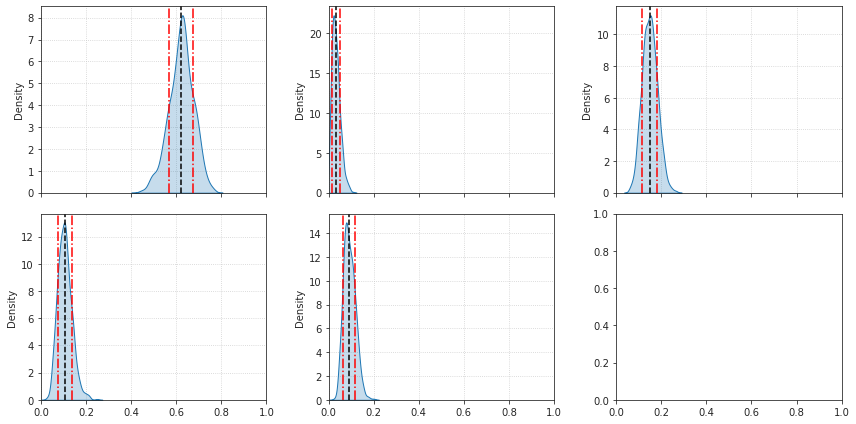

In [55]:
i, j, k = 3, 1, 2
kk = 0
nn = 13

means = []

fig, axes = create_figure(2, 3, (12, 6), 'all')
for kk in range(5):
    ax = axes.flat[kk]
    mu, sd = bn.nanmean(b_pi[:, kk, nn]), np.nanstd(b_pi[:, kk, nn], ddof=1)
    means.append(mu)

    sns.kdeplot(b_pi[:, kk, nn], fill=True, ax=ax)
    ax.axvline(mu, ls='--', color='k')
    ax.axvline(mu - sd, ls='-.', color='r')
    ax.axvline(mu + sd, ls='-.', color='r')
    ax.set_xlim(0, 1)
    ax.grid()
# trim_axs(axes, 5)
plt.show()

In [56]:
k, n = b.shape[-2:]
cut, _ = cut_data(
    data=b.reshape(-1, k, n),
    bins=gr_bold.bins,
    oc_only=True,
)
cut = cut.reshape((*b.shape[:-2], k, -1))
cut.shape

(1000, 10, 3, 4, 5, 4)

In [57]:
cut_avg = bn.nanmean(bn.nanmean(bn.nanmean(cut, 3), 2), 1)
cut_avg.shape

(1000, 5, 4)

In [58]:
np.nanmean(cut_avg, 0)

array([[26.73533513, 20.48613509, 18.2968405 , 34.48168928],
       [24.51226449, 19.97657504, 19.60514594, 35.90601453],
       [22.77329996, 16.94697754, 17.57707526, 42.70264724],
       [33.92946954, 24.35123915, 20.74500366, 20.97428765],
       [36.53444558, 22.99750141, 16.67565264, 23.79240037]])

In [59]:
gr_bold.grp_cut

memmap([[35.25878693, 24.28579604, 18.84041316, 21.61500387],
        [31.49803327, 23.17122317, 24.00660292, 21.32414064],
        [28.9771541 , 19.50553565, 19.69573704, 31.8215732 ],
        [42.91457401, 29.34498867, 20.56416208,  7.17627524],
        [45.9183388 , 23.75434539, 20.76910568,  9.55821013]])

In [60]:
np.nanstd(cut_avg, 0, ddof=1)

array([[1.71076607, 1.65939907, 1.18350936, 2.90741477],
       [1.69833158, 1.28633078, 1.46881582, 2.96761624],
       [1.61138589, 1.29342123, 1.16711916, 2.63666741],
       [1.85328411, 1.26016671, 1.25115914, 1.98255324],
       [2.36345799, 1.4741328 , 1.0180326 , 2.26742571]])